# Supplementary figure 1

This notebook contains the functions used to construct the supplementary figure 1 in the paper. 

The figure shows the relationship between the exon/intron content of the genes with their mutation rate in colorectal POLE-mutant tumors. Genes are grouped according to the proportion of interanl exons to introns.


---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
from os import path

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd

from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params()

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type

### Other

- tumor_type: id of the tumor
- cluster_id: id of the cluster
- n_groups: amount of groups for the genes (bins)

---

In addition, this notebook requires the output of the **gene_and_sample_analysis** notebook.

In [4]:
# Included
clusters_file = 'data/clusters.tsv'

# Ohter
tumor_type = 'crc'
cluster_id = 'clusterA'
n_groups = 10

In [7]:
clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
sub_clust = clusters_df[clusters_df['ctype'] == tumor_type]

print(tumor_type, cluster_id)

gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other netbook
sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (tumor_type, cluster_id))  # Output from other notebook

genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

my_genes =  genelvl_results_df['ensembl'].tolist()

my_genelevel_exp = list()

for my_gene in my_genes:
    sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
    sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

    exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
    introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

    exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
    introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

    exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
    intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

    total_muts = exon_muts+intron_muts

    exp_exon_muts = total_muts*exons_prob
    exp_intron_muts = total_muts*introns_prob

    syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
    nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

    syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
    nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

    syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
    nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

    total_cons_muts = syn_muts+nonsyn_muts

    exp_syn_muts = total_cons_muts*syn_prob
    exp_nonsyn_muts = total_cons_muts*nonsyn_prob

    exons_bp = sub_genelvl_results['exons_bp'].values[0]
    introns_bp = sub_genelvl_results['introns_bp'].values[0]

    my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                             exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                             exp_nonsyn_muts, exons_bp, introns_bp])

my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                               'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                               'exp_nonsyn_muts', 'exons_bp', 'introns_bp']

my_df = my_genelevel_exp_df.copy()

my_df['mutrate'] = ((my_df['exon_muts'] + my_df['intron_muts']) /
                            (my_df['exons_bp'] + my_df['introns_bp']))

my_df['exon_intron_prop'] = my_df['exons_bp']/my_df['introns_bp']

my_df = my_df.sort_values(by='exon_intron_prop')

my_df.to_csv(path.join('results', 'data_suppFigure1.csv'), sep="\t", index=False)

crc clusterA


## Plot data

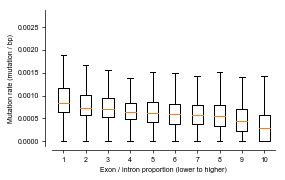

In [5]:
my_df = pd.read_csv(path.join('results', 'data_suppFigure1.csv'), sep='\t')

groups_size = int(len(my_df.index.tolist()) / n_groups)

mutrate_levels = dict()

for i in range(n_groups):
    my_start = i * groups_size
    my_end = (i + 1) * groups_size

    if i == max(range(n_groups)):
        my_end = len(my_df.index.tolist())

    sub_exin_prop_df = my_df.iloc[my_start:my_end]
    sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

    mutrate_levels[i] = sub_exin_genes

exons_results_prop = list()
introns_results_prop = list()

mutrates_to_plot = list()

for mutrate_level in mutrate_levels:
    genes_list = mutrate_levels[mutrate_level]

    my_mutrates = my_df[my_df['ensembl'].isin(genes_list)]['mutrate'].tolist()
    mutrates_to_plot.append(my_mutrates)

    
# TODO split code computation and plot creation or remove the last line in the first box
    
fig = plt.figure(figsize=(4, 2.5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.margins(0.1)

bp = ax.boxplot(mutrates_to_plot, showfliers=False)

ax.set_ylabel('Mutation rate (mutation / bp)')
ax.set_xlabel('Exon / intron proportion (lower to higher)')

ax.set_ylim(-0.0001, np.percentile(my_df['mutrate'], 99.9))

loc = plticker.MultipleLocator(base=1) 
ax.xaxis.set_major_locator(loc)
#ax.set_xlim(1, 10)

# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9', '10'])
plt.savefig(path.join('figures', 'figureS1.svg'), bbox_inches='tight' )
plt.show()